# Analyze decision threshold
We notice that some models always predict 1 for binary_A. We try modifiying the decision threshold and see the impact on validation metrics

In [86]:
import pathlib
import sys
sys.path.append(str(pathlib.Path("__file__").absolute().parents[1]))

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, fbeta_score, PrecisionRecallDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb

from src.util.definitions import PRED_DIR, DATA_ROOT, LOG_DIR
from src.util.io import read_predictions
from ghost import optimize_threshold_from_predictions

In [14]:
api = wandb.Api(timeout=59)
runs = api.runs("jugoetz/synferm-predictions", filters={"group": "2023-12-20-202602_330364"})  # best 0D model JG1309

In [15]:
# get run info
config_list = [run.config for run in runs]
summary_list = [run.summary._json_dict for run in runs]
name_list = [run.name for run in runs]

name_list

['2023-12-20-202602_330364_fold8',
 '2023-12-20-202602_330364_fold7',
 '2023-12-20-202602_330364_fold6',
 '2023-12-20-202602_330364_fold5',
 '2023-12-20-202602_330364_fold4',
 '2023-12-20-202602_330364_fold3',
 '2023-12-20-202602_330364_fold2',
 '2023-12-20-202602_330364_fold1',
 '2023-12-20-202602_330364_fold0']

In [16]:
# read train predictions
preds = [read_predictions(n, "train") for n in name_list]
preds[0]

,pred_0,pred_1,pred_2
idx,,,
16792,0.021305,0.135745,0.011207
30296,0.169326,0.061242,0.008215
18358,0.999845,0.999635,0.998481
21011,0.998878,0.004433,0.073672
16368,0.552459,0.139664,0.112130
...,...,...,...
9692,0.999995,0.999908,0.004738
31842,1.000000,0.999984,0.986404
28875,0.998983,0.069298,0.067562


In [17]:
# combine with ground truth
df_true = pd.read_csv(DATA_ROOT / "synferm_dataset_2023-12-20_39486records.csv")
comb = [pred.merge(df_true[["binary_A", "binary_B", "binary_C"]], left_index=True, right_index=True) for pred in preds]
comb[0]

,pred_0,pred_1,pred_2,binary_A,binary_B,binary_C
16792,0.021305,0.135745,0.011207,0,0,0
30296,0.169326,0.061242,0.008215,0,0,0
18358,0.999845,0.999635,0.998481,1,1,1
21011,0.998878,0.004433,0.073672,1,0,0
16368,0.552459,0.139664,0.112130,0,0,0
...,...,...,...,...,...,...
9692,0.999995,0.999908,0.004738,1,1,0
31842,1.000000,0.999984,0.986404,1,1,1
28875,0.998983,0.069298,0.067562,1,0,0
22913,0.999999,1.000000,0.376397,1,1,0


In [18]:
# calculate thresholded metrics over many thresholds
# and obtain best threshold with GHOST with Cohen's Kappa method
bal_acc = []
f_beta = []
x = np.arange(0, 1.0001, 0.01)
y_bal_acc = np.empty((101, 9))
y_f_beta = np.empty((101, 9))
best_thresh = np.empty(9)
for fold in range(9):
    for i, threshold in enumerate(x):
        y_bal_acc[i, fold] = balanced_accuracy_score(comb[fold]["binary_A"], (comb[fold]["pred_0"] > threshold))
        y_f_beta[i, fold] = fbeta_score(comb[fold]["binary_A"], (comb[fold]["pred_0"] > threshold), beta=0.1)
    best_thresh[fold] = optimize_threshold_from_predictions(comb[fold]["binary_A"], comb[fold]["pred_0"], thresholds=x, ThOpt_metrics="Kappa") 

In [19]:
# obtain best threshold with GHOST with AUROC method
best_thresh_roc = np.empty(9)
for fold in range(9):
    best_thresh_roc[fold] = optimize_threshold_from_predictions(comb[fold]["binary_A"], comb[fold]["pred_0"], thresholds=x, ThOpt_metrics="ROC") 

In [20]:
best_thresh

array([0.57, 0.56, 0.59, 0.54, 0.57, 0.59, 0.56, 0.55, 0.59])

In [21]:
best_thresh_roc

array([0.74, 0.72, 0.71, 0.72, 0.71, 0.72, 0.73, 0.72, 0.71])

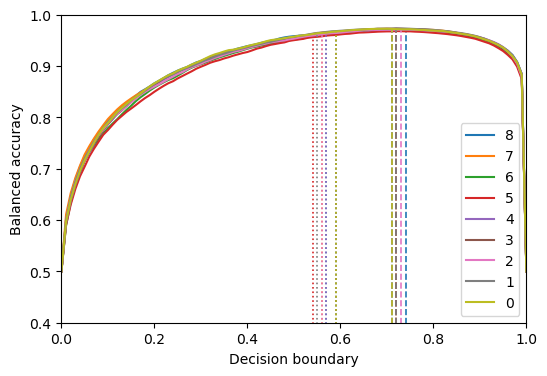

In [22]:
# plot best thresholds from GHOST with metric value by threshold
fig, ax = plt.subplots(figsize=(6,4))
for i, fold in enumerate(name_list):
    line = ax.plot(x, y_bal_acc[:, i], label=fold[-1])
    ax.vlines(x=best_thresh[i], ymin=0, ymax=y_bal_acc[int((best_thresh[i] * 100).round()), i], ls=":", colors=line[0].get_color(), lw=1.2)
    ax.vlines(x=best_thresh_roc[i], ymin=0, ymax=y_bal_acc[int((best_thresh_roc[i] * 100).round()), i], ls="--", colors=line[0].get_color(), lw=1.2)

ax.set_xlabel("Decision boundary")
ax.set_ylabel("Balanced accuracy")
ax.set_xlim(0,1)
ax.set_ylim(0.4,1)
ax.legend()

### Maximize balanced accuracy

Simple way to pick the decision threshold is to calculate the balanced accuracy over different thresholds and pick the one that maximizes it.

Note:
- Since this is average recall per class, for our problem, this heavily tilts the predictions to minimize false negatives. That also means, recall for the positive class will take a heavy hit
- Picking the maximum can be a bit unstable if the balanced_accuracy/threshold curve is not so smooth.

balanced accuracy: 0.97
recall: 0.97
precision: 0.99
f_0.5 score: 0.99

balanced accuracy: 0.97
recall: 0.97
precision: 0.99
f_0.5 score: 0.99

balanced accuracy: 0.97
recall: 0.97
precision: 0.99
f_0.5 score: 0.99

balanced accuracy: 0.97
recall: 0.96
precision: 0.99
f_0.5 score: 0.99

balanced accuracy: 0.97
recall: 0.96
precision: 1.00
f_0.5 score: 0.99

balanced accuracy: 0.97
recall: 0.97
precision: 0.99
f_0.5 score: 0.99

balanced accuracy: 0.97
recall: 0.97
precision: 0.99
f_0.5 score: 0.99

balanced accuracy: 0.97
recall: 0.97
precision: 1.00
f_0.5 score: 0.99

balanced accuracy: 0.97
recall: 0.97
precision: 0.99
f_0.5 score: 0.99



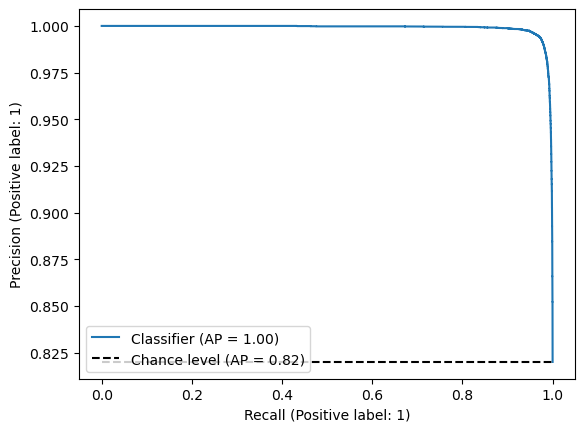

In [23]:
# try maximizing balanced accuracy on all folds
for fold in range(9):
    threshold = np.argmax(y_bal_acc[:, fold]) / 100
    y_true = comb[fold]["binary_A"]
    y_prob = comb[fold]["pred_0"]
    y_pred = (y_prob > threshold)
    print("balanced accuracy:", f"{balanced_accuracy_score(y_true, y_pred):.2f}")
    print("recall:", f"{recall_score(y_true, y_pred):.2f}")
    print("precision:", f"{precision_score(y_true, y_pred):.2f}")
    print("f_0.5 score:", f"{fbeta_score(y_true, y_pred, beta=0.5):.2f}")
    print()

# plot the PRC
PrecisionRecallDisplay.from_predictions(y_true, y_prob, pos_label=1, drop_intermediate=True, plot_chance_level=True)

### GHOST
The Rinicker lab has published GHOST (1) for decision threshold picking.
On a high level this:
- Takes startified samples from the training set (default: without replacement)
- Determines metric (default: Cohen's kappa) for all decision thresholds
- Calculates the median metric over stratified samples for all decision thresholds
- Returns the threshold with highest median metric

(1) Esposito, C.; A. Landrum, G.; Schneider, N.; Stiefl, N.; Riniker, S. GHOST: Adjusting the Decision Threshold to Handle Imbalanced Data in Machine Learning. Journal of Chemical Information and Modeling 2021, 61 (6), 2623–2640. https://doi.org/10.1021/acs.jcim.1c00160.

In [24]:
# evaluate GHOST on all folds (training data)
for i in range(9):
    threshold = best_thresh[i]
    y_true = comb[i]["binary_A"]
    y_prob = comb[i]["pred_0"]
    y_pred = (y_prob > threshold)
    print("balanced accuracy:", f"{balanced_accuracy_score(y_true, y_pred):.2f}")
    print("recall:", f"{recall_score(y_true, y_pred):.2f}")
    print("precision:", f"{precision_score(y_true, y_pred):.2f}")
    print("f_0.5 score:", f"{fbeta_score(y_true, y_pred, beta=0.5):.2f}")
    print()

balanced accuracy: 0.97
recall: 0.98
precision: 0.99
f_0.5 score: 0.99

balanced accuracy: 0.97
recall: 0.98
precision: 0.99
f_0.5 score: 0.99

balanced accuracy: 0.96
recall: 0.98
precision: 0.99
f_0.5 score: 0.99

balanced accuracy: 0.96
recall: 0.98
precision: 0.98
f_0.5 score: 0.98

balanced accuracy: 0.96
recall: 0.98
precision: 0.99
f_0.5 score: 0.99

balanced accuracy: 0.97
recall: 0.98
precision: 0.99
f_0.5 score: 0.99

balanced accuracy: 0.96
recall: 0.98
precision: 0.99
f_0.5 score: 0.99

balanced accuracy: 0.96
recall: 0.98
precision: 0.99
f_0.5 score: 0.99

balanced accuracy: 0.97
recall: 0.98
precision: 0.99
f_0.5 score: 0.99



In [25]:
# take a look at validation set metrics
# read val predictions
preds_val = [read_predictions(n, "val") for n in name_list]
preds_val[0]

,pred_0,pred_1,pred_2
idx,,,
19658,1.000000,1.000000,0.996722
12101,0.947750,0.854873,0.024114
4975,1.000000,0.999871,0.999230
5717,1.000000,0.999991,0.019596
34257,0.999650,0.966365,0.371201
...,...,...,...
34487,0.999914,0.999947,0.118084
39022,1.000000,1.000000,0.000444
17255,0.964072,0.966160,0.168545


In [26]:
# combine with ground truth
comb_val = [pred.merge(df_true[["binary_A", "binary_B", "binary_C"]], left_index=True, right_index=True) for pred in preds_val]
comb_val[0]

,pred_0,pred_1,pred_2,binary_A,binary_B,binary_C
19658,1.000000,1.000000,0.996722,1,1,1
12101,0.947750,0.854873,0.024114,1,1,0
4975,1.000000,0.999871,0.999230,1,1,1
5717,1.000000,0.999991,0.019596,1,1,0
34257,0.999650,0.966365,0.371201,1,0,1
...,...,...,...,...,...,...
34487,0.999914,0.999947,0.118084,1,1,0
39022,1.000000,1.000000,0.000444,1,1,0
17255,0.964072,0.966160,0.168545,1,1,0
36091,0.975732,0.999997,0.016057,1,1,0


In [27]:
# threshold obtained by GHOST with Kappa
acc, bal_acc, recall, precision, fbeta = [], [], [], [], []

for fold in range(9):
    threshold = best_thresh[fold]
    y_true = comb_val[fold]["binary_A"]
    y_prob = comb_val[fold]["pred_0"]
    y_pred = (y_prob > threshold)
    acc.append(accuracy_score(y_true, y_pred))
    bal_acc.append(balanced_accuracy_score(y_true, y_pred))
    recall.append(recall_score(y_true, y_pred))
    precision.append(precision_score(y_true, y_pred))
    fbeta.append(fbeta_score(y_true, y_pred, beta=0.5))

print("accuracy:", f"{np.array(acc).mean():.2f}±{np.array(acc).std():.2f}")
print("balanced accuracy:", f"{np.array(bal_acc).mean():.2f}±{np.array(bal_acc).std():.2f}")
print("recall:", f"{np.array(recall).mean():.2f}±{np.array(recall).std():.2f}")
print("precision:", f"{np.array(precision).mean():.2f}±{np.array(precision).std():.2f}")
print("f_0.5 score:", f"{np.array(fbeta).mean():.2f}±{np.array(fbeta).std():.2f}")

accuracy: 0.95±0.00
balanced accuracy: 0.92±0.00
recall: 0.97±0.00
precision: 0.97±0.00
f_0.5 score: 0.97±0.00


In [28]:
# threshold obtained by GHOST with ROC
acc, bal_acc, recall, precision, fbeta = [], [], [], [], []

for fold in range(9):
    threshold = best_thresh_roc[fold]
    y_true = comb_val[fold]["binary_A"]
    y_prob = comb_val[fold]["pred_0"]
    y_pred = (y_prob > threshold)
    acc.append(accuracy_score(y_true, y_pred))
    bal_acc.append(balanced_accuracy_score(y_true, y_pred))
    recall.append(recall_score(y_true, y_pred))
    precision.append(precision_score(y_true, y_pred))
    fbeta.append(fbeta_score(y_true, y_pred, beta=0.5))

print("accuracy:", f"{np.array(acc).mean():.2f}±{np.array(acc).std():.2f}")
print("balanced accuracy:", f"{np.array(bal_acc).mean():.2f}±{np.array(bal_acc).std():.2f}")
print("recall:", f"{np.array(recall).mean():.2f}±{np.array(recall).std():.2f}")
print("precision:", f"{np.array(precision).mean():.2f}±{np.array(precision).std():.2f}")
print("f_0.5 score:", f"{np.array(fbeta).mean():.2f}±{np.array(fbeta).std():.2f}")

accuracy: 0.94±0.00
balanced accuracy: 0.93±0.00
recall: 0.95±0.00
precision: 0.98±0.00
f_0.5 score: 0.97±0.00


In [29]:
best_tresh_bal_acc =  np.argmax(y_bal_acc, axis=0) / 100
best_tresh_bal_acc

array([0.72, 0.72, 0.71, 0.72, 0.74, 0.7 , 0.73, 0.72, 0.7 ])

In [30]:
# threshold obtained by maximizing balanced accuracy

acc, bal_acc, recall, precision, fbeta = [], [], [], [], []

for fold in range(9):
    threshold = np.argmax(y_bal_acc[:, fold]) / 100
    y_true = comb_val[fold]["binary_A"]
    y_prob = comb_val[fold]["pred_0"]
    y_pred = (y_prob > threshold)
    acc.append(accuracy_score(y_true, y_pred))
    bal_acc.append(balanced_accuracy_score(y_true, y_pred))
    recall.append(recall_score(y_true, y_pred))
    precision.append(precision_score(y_true, y_pred))
    fbeta.append(fbeta_score(y_true, y_pred, beta=0.5))

print("accuracy:", f"{np.array(acc).mean():.2f}±{np.array(acc).std():.2f}")
print("balanced accuracy:", f"{np.array(bal_acc).mean():.2f}±{np.array(bal_acc).std():.2f}")
print("recall:", f"{np.array(recall).mean():.2f}±{np.array(recall).std():.2f}")
print("precision:", f"{np.array(precision).mean():.2f}±{np.array(precision).std():.2f}")
print("f_0.5 score:", f"{np.array(fbeta).mean():.2f}±{np.array(fbeta).std():.2f}")

accuracy: 0.94±0.00
balanced accuracy: 0.93±0.00
recall: 0.95±0.00
precision: 0.98±0.00
f_0.5 score: 0.97±0.00


In [31]:
# fixed threshold at 0.5

acc, bal_acc, recall, precision, fbeta = [], [], [], [], []

for fold in range(9):
    threshold = 0.5
    y_true = comb_val[fold]["binary_A"]
    y_prob = comb_val[fold]["pred_0"]
    y_pred = (y_prob > threshold)
    acc.append(accuracy_score(y_true, y_pred))
    bal_acc.append(balanced_accuracy_score(y_true, y_pred))
    recall.append(recall_score(y_true, y_pred))
    precision.append(precision_score(y_true, y_pred))
    fbeta.append(fbeta_score(y_true, y_pred, beta=0.5))

print("accuracy:", f"{np.array(acc).mean():.2f}±{np.array(acc).std():.2f}")
print("balanced accuracy:", f"{np.array(bal_acc).mean():.2f}±{np.array(bal_acc).std():.2f}")
print("recall:", f"{np.array(recall).mean():.2f}±{np.array(recall).std():.2f}")
print("precision:", f"{np.array(precision).mean():.2f}±{np.array(precision).std():.2f}")
print("f_0.5 score:", f"{np.array(fbeta).mean():.2f}±{np.array(fbeta).std():.2f}")

accuracy: 0.95±0.00
balanced accuracy: 0.90±0.01
recall: 0.97±0.00
precision: 0.96±0.00
f_0.5 score: 0.97±0.00


In [32]:
# threshold equal to training data distribution

acc, bal_acc, recall, precision, fbeta = [], [], [], [], []

for fold in range(9):
    threshold = comb[fold]["binary_A"].mean()
    y_true = comb_val[fold]["binary_A"]
    y_prob = comb_val[fold]["pred_0"]
    y_pred = (y_prob > threshold)
    acc.append(accuracy_score(y_true, y_pred))
    bal_acc.append(balanced_accuracy_score(y_true, y_pred))
    recall.append(recall_score(y_true, y_pred))
    precision.append(precision_score(y_true, y_pred))
    fbeta.append(fbeta_score(y_true, y_pred, beta=0.5))

print("accuracy:", f"{np.array(acc).mean():.2f}±{np.array(acc).std():.2f}")
print("balanced accuracy:", f"{np.array(bal_acc).mean():.2f}±{np.array(bal_acc).std():.2f}")
print("recall:", f"{np.array(recall).mean():.2f}±{np.array(recall).std():.2f}")
print("precision:", f"{np.array(precision).mean():.2f}±{np.array(precision).std():.2f}")
print("f_0.5 score:", f"{np.array(fbeta).mean():.2f}±{np.array(fbeta).std():.2f}")

accuracy: 0.93±0.00
balanced accuracy: 0.94±0.00
recall: 0.93±0.00
precision: 0.99±0.00
f_0.5 score: 0.98±0.00


## Conclusion

Using GHOST with Cohen's Kappa gives the best results.
We will use the thresholds obtained this way for our final predictions

In [48]:
# save best thresholds for this model
for thresh, name in zip(best_thresh, name_list):
    with open(LOG_DIR / "thresholds" / f"{name}.txt", "w") as f:
        f.write(f"{thresh}\n")

## Faster way to pick decision treshold
Given a run_group, identify and save all the decision thresholds using GHOST with Cohen's kappa


In [33]:
def get_decision_thresholds(run_group: str) -> None:
    """
    Given a run group, identify and save all the decision thresholds using GHOST with Cohen's kappa.
    Best thresholds are saved to a txt file with 3 lines.
    The 1st line is the threshold for target binary_A, the 2nd for binary_B, and the 3rd for binary_C.
    If the run_group contains multiple runs, one txt file is generated per run.
    
    Args: 
        run_group (str): Name of a run_group present in the wandb database.
    Returns:
        None
    Raises:
        ValueError: Raised if no runs are found in WandB for the run_group
        RuntimeError: Raised if the predictions for a run are not found on disk.
    """
    # get runs from wandb
    api = wandb.Api(timeout=59)
    runs = api.runs("jugoetz/synferm-predictions", filters={"group": run_group})
    name_list = [run.name for run in runs]
    if len(name_list) == 0:
        raise ValueError(f"No runs found for run_group {run_group}.")
        
    # read train predictions
    try:
        preds = [read_predictions(n, "train") for n in name_list]
    except FileNotFoundError as e:
        raise RuntimeError(f"Did not find all predictions for runs {name_list}. Exception leading to this: {e}")
    
    # combine predictions with ground truth
    df_true = pd.read_csv(DATA_ROOT / "synferm_dataset_2023-12-20_39486records.csv")
    comb = [pred.merge(df_true[["binary_A", "binary_B", "binary_C"]], left_index=True, right_index=True) for pred in preds]
    
    # obtain best threshold with GHOST with Cohen's Kappa method
    print(f"Running GHOST for {len(name_list)} runs. This may take a while...")
    best_thresh = np.empty((len(name_list), 3))
    thresholds = np.arange(0, 1.0001, 0.01)
    for run_idx in range(len(name_list)):
        for i, target in enumerate("ABC"):
            best_thresh[run_idx, i] = optimize_threshold_from_predictions(
                comb[run_idx][f"binary_{target}"], 
                comb[run_idx][f"pred_{i}"], 
                thresholds=thresholds, 
                ThOpt_metrics="Kappa",
                random_seed=42, # we seed for reproducible results
            )
    
    # write thresholds to disk
    for threshs, name in zip(best_thresh, name_list):
        with open(LOG_DIR / "thresholds" / f"{name}.txt", "w") as f:
            for thresh in threshs:
                f.write(f"{thresh:.2f}\n")
    print(best_thresh)

In [8]:
def get_inverse_class_distribution(run_group: str) -> None:
    """
    An alternative is to set the decision boundary to the class distribution.
    Note that this is a quite extreme measure and is interesting mostly as a reference point.
    Here we only need to know the split, but for convenience we can get this from the run group (through train indices)
    Best thresholds are saved to a txt file with 3 lines.
    The 1st line is the threshold for target binary_A, the 2nd for binary_B, and the 3rd for binary_C.
    If the run_group contains multiple runs, one txt file is generated per run.
    
    Args: 
        run_group (str): Name of a run_group present in the wandb database.
    Returns:
        None
    Raises:
        ValueError: Raised if no runs are found in WandB for the run_group
        RuntimeError: Raised if the predictions for a run are not found on disk.
    """
    # get runs from wandb
    api = wandb.Api(timeout=59)
    runs = api.runs("jugoetz/synferm-predictions", filters={"group": run_group})
    name_list = [run.name for run in runs]
    if len(name_list) == 0:
        raise ValueError(f"No runs found for run_group {run_group}.")
        
    # read train predictions
    try:
        preds = [read_predictions(n, "train") for n in name_list]
    except FileNotFoundError as e:
        raise RuntimeError(f"Did not find all predictions for runs {name_list}. Exception leading to this: {e}")
    
    # combine predictions with ground truth
    df_true = pd.read_csv(DATA_ROOT / "synferm_dataset_2023-12-20_39486records.csv")
    comb = [pred.merge(df_true[["binary_A", "binary_B", "binary_C"]], left_index=True, right_index=True) for pred in preds]
    
    # obtain class distributions
    best_thresh = np.empty((len(name_list), 3))
    for run_idx in range(len(name_list)):
        for i, target in enumerate("ABC"):
            best_thresh[run_idx, i] = comb[run_idx][f"binary_{target}"].mean()
                
    
    # write thresholds to disk
    for threshs, name in zip(best_thresh, name_list):
        with open(LOG_DIR / "thresholds" / f"{name}.txt", "w") as f:
            for thresh in threshs:
                f.write(f"{thresh:.2f}\n")
    print(best_thresh)

In [21]:
# the best OD model from validation (JG1309, FFN/OHE)
get_decision_thresholds("2023-12-20-202602_330364")

Running GHOST for 9 runs. This may take a while...
[[0.55 0.5  0.41]
 [0.56 0.52 0.48]
 [0.54 0.52 0.46]
 [0.54 0.54 0.46]
 [0.57 0.53 0.47]
 [0.59 0.54 0.5 ]
 [0.57 0.52 0.45]
 [0.55 0.52 0.44]
 [0.55 0.52 0.46]]


In [15]:
# the OD production model (JG1349, FFN/OHE)
get_decision_thresholds("2024-01-30-112912_514212")

Running GHOST for 1 runs. This may take a while...
[[0.55 0.53 0.49]]


In [34]:
# the best XGB/FP models (JG1486, 1D)
get_decision_thresholds("2024-01-23-063840_864375")

Running GHOST for 9 runs. This may take a while...
[[0.59 0.51 0.47]
 [0.66 0.57 0.45]
 [0.66 0.56 0.52]
 [0.66 0.51 0.51]
 [0.61 0.52 0.46]
 [0.62 0.53 0.44]
 [0.65 0.5  0.44]
 [0.63 0.53 0.47]
 [0.64 0.55 0.44]]


In [87]:
# the XGB/FP modelfor Euan on 27 folds (JG1526, 1D)
get_decision_thresholds("2024-02-23-134822_777158")

Running GHOST for 27 runs. This may take a while...
[[0.63 0.55 0.42]
 [0.6  0.57 0.48]
 [0.62 0.55 0.49]
 [0.67 0.54 0.46]
 [0.65 0.51 0.46]
 [0.63 0.5  0.45]
 [0.64 0.53 0.52]
 [0.61 0.5  0.49]
 [0.61 0.55 0.48]
 [0.64 0.51 0.46]
 [0.63 0.54 0.41]
 [0.6  0.54 0.49]
 [0.63 0.51 0.48]
 [0.62 0.55 0.49]
 [0.59 0.5  0.5 ]
 [0.64 0.53 0.47]
 [0.64 0.57 0.44]
 [0.65 0.53 0.43]
 [0.62 0.52 0.46]
 [0.64 0.56 0.45]
 [0.63 0.53 0.42]
 [0.64 0.54 0.45]
 [0.62 0.53 0.44]
 [0.62 0.51 0.41]
 [0.65 0.5  0.44]
 [0.63 0.53 0.47]
 [0.64 0.55 0.44]]


In [27]:
# the best XGB/FP models (JG1495, 2D)
get_decision_thresholds("2024-01-25-192032_503662")

Running GHOST for 9 runs. This may take a while...
[[0.63 0.52 0.41]
 [0.65 0.45 0.46]
 [0.62 0.43 0.46]
 [0.57 0.52 0.44]
 [0.68 0.65 0.47]
 [0.6  0.47 0.41]
 [0.63 0.56 0.46]
 [0.65 0.6  0.4 ]
 [0.64 0.46 0.45]]


In [28]:
# the best XGB/FP models (JG1504, 3D)
get_decision_thresholds("2024-01-26-161936_145583")

Running GHOST for 9 runs. This may take a while...
[[0.59 0.5  0.45]
 [0.61 0.54 0.46]
 [0.67 0.66 0.49]
 [0.6  0.48 0.48]
 [0.47 0.47 0.43]
 [0.65 0.58 0.51]
 [0.55 0.5  0.45]
 [0.72 0.43 0.44]
 [0.57 0.51 0.44]]


### Thresholded metrics for test scores of best models
(i.e. we evaluate the models that were selected based on validation performance)

In [70]:
records = []

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay

In [72]:
# get the thresholded metrics for these models
# 0D
api = wandb.Api(timeout=59)
runs = api.runs("jugoetz/synferm-predictions", filters={"group": "2023-12-20-202602_330364"})

# get run info
config_list = [run.config for run in runs]
summary_list = [run.summary._json_dict for run in runs]
name_list = [run.name for run in runs]

# read val predictions
preds = [read_predictions(n, "test") for n in name_list]
# combine with ground truth
df_true = pd.read_csv(DATA_ROOT / "synferm_dataset_2023-12-20_39486records.csv")
comb = [pred.merge(df_true[["binary_A", "binary_B", "binary_C"]], left_index=True, right_index=True) for pred in preds]

# load decision thresholds
threshs = []
for name in name_list:
    with open(LOG_DIR / "thresholds" / f"{name}.txt", "r") as f:
        threshs.append([float(i) for i in f.readlines()])
threshs = np.array(threshs)

# get truth
fold_true = [comb[i][["binary_A", "binary_B", "binary_C"]].to_numpy() for i in range(len(name_list))]

# get preds by applying the thresholds
fold_preds = []
for fold_i in range(len(name_list)):
    fold_preds.append(np.stack([np.where(preds[fold_i].to_numpy()[:, i] > threshs[fold_i, i], 1, 0) for i in range(3)], axis=1))

# evaluate
acc, bal_acc, recall, precision, fbeta = np.zeros((len(name_list), 3)), np.zeros((len(name_list), 3)), np.zeros((len(name_list), 3)), np.zeros((len(name_list), 3)), np.zeros((len(name_list), 3))

for fold in range(len(name_list)):
    for target in range(3):
        threshold = threshs[fold]
        y_true = fold_true[fold][:, target]
        y_pred = fold_preds[fold][:, target]
        acc[fold, target] = accuracy_score(y_true, y_pred)
        bal_acc[fold, target] = balanced_accuracy_score(y_true, y_pred)
        recall[fold, target] = recall_score(y_true, y_pred)
        precision[fold, target] = precision_score(y_true, y_pred)
        fbeta[fold, target] = fbeta_score(y_true, y_pred, beta=0.5)
        print(confusion_matrix(y_true, y_pred))

for i, name in enumerate(name_list):
    records.append({"name": name, "split": "0D", "metric": "accuracy", "target": "macro", "value": acc[i].mean()})
    records.append({"name": name, "split": "0D", "metric": "recall", "target": "macro", "value": recall[i].mean()})
    records.append({"name": name, "split": "0D", "metric": "precision", "target": "macro", "value": precision[i].mean()})
    records.append({"name": name, "split": "0D", "metric": "accuracy", "target": "A", "value": acc[i, 0]})
    records.append({"name": name, "split": "0D", "metric": "recall", "target": "A", "value": recall[i, 0]})
    records.append({"name": name, "split": "0D", "metric": "precision", "target": "A", "value": precision[i, 0]})


print("Mean macro accuracy:", f"{acc.mean():.2f}±{acc.mean(axis=1).std():.3f}")
print("Mean macro recall:", f"{recall.mean():.2f}±{recall.mean(axis=1).std():.3f}")
print("Mean macro precision:", f"{precision.mean():.2f}±{precision.mean(axis=1).std():.3f}")
#print("Mean macro balanced accuracy:", f"{bal_acc.mean():.2f}±{bal_acc.mean(axis=1).std():.2f}")
#print("Mean macro f_0.5 score:", f"{fbeta.mean():.2f}±{fbeta.mean(axis=1).std():.2f}")

print("Mean target_A accuracy:", f"{acc[:, 0].mean():.2f}±{acc[:, 0].std():.3f}")
print("Mean target_A recall:", f"{recall[:, 0].mean():.2f}±{recall[:, 0].std():.3f}")
print("Mean target_A precision:", f"{precision[:, 0].mean():.2f}±{precision[:, 0].std():.3f}")
#print("Mean target_A balanced accuracy:", f"{bal_acc[:, 0].mean():.2f}±{bal_acc[:, 0].std():.2f}")
#print("Mean target_A f_0.5 score:", f"{fbeta[:, 0].mean():.2f}±{fbeta[:, 0].std():.2f}")

[[ 615   99]
 [  98 3137]]
[[1526  136]
 [ 162 2125]]
[[2640  172]
 [ 231  906]]
[[ 595   98]
 [ 122 3134]]
[[1547  122]
 [ 187 2093]]
[[2722  132]
 [ 222  873]]
[[ 623   99]
 [ 108 3119]]
[[1572  120]
 [ 172 2085]]
[[2672  136]
 [ 225  916]]
[[ 588  116]
 [ 100 3145]]
[[1504  137]
 [ 168 2140]]
[[2666  133]
 [ 232  918]]
[[ 634  103]
 [ 110 3102]]
[[1619   99]
 [ 171 2060]]
[[2688  139]
 [ 204  918]]
[[ 638  101]
 [ 112 3098]]
[[1534  117]
 [ 188 2110]]
[[2691  119]
 [ 246  893]]
[[ 632   92]
 [ 111 3114]]
[[1538  100]
 [ 175 2136]]
[[2708  146]
 [ 198  897]]
[[ 623  113]
 [ 111 3102]]
[[1580  153]
 [ 191 2025]]
[[2710  156]
 [ 202  881]]
[[ 586  117]
 [  95 3151]]
[[1556  121]
 [ 166 2106]]
[[2688  137]
 [ 221  903]]
Mean macro accuracy: 0.93±0.003
Mean macro recall: 0.90±0.004
Mean macro precision: 0.93±0.006
Mean target_A accuracy: 0.95±0.002
Mean target_A recall: 0.97±0.002
Mean target_A precision: 0.97±0.002


In [73]:
y_true

array([0, 0, 0, ..., 0, 0, 0])

In [74]:
confusion_matrix(y_true, y_pred)

array([[2688,  137],
       [ 221,  903]])

In [81]:
# get the thresholded metrics for these models
# 1D
api = wandb.Api()
runs = api.runs("jugoetz/synferm-predictions", filters={"group": "2024-01-23-063840_864375"})

# get run info
config_list = [run.config for run in runs]
summary_list = [run.summary._json_dict for run in runs]
name_list = [run.name for run in runs]

# read val predictions
preds = [read_predictions(n, "test") for n in name_list]
# combine with ground truth
df_true = pd.read_csv(DATA_ROOT / "synferm_dataset_2023-12-20_39486records.csv")
comb = [pred.merge(df_true[["binary_A", "binary_B", "binary_C"]], left_index=True, right_index=True) for pred in preds]

# load decision thresholds
threshs = []
for name in name_list:
    with open(LOG_DIR / "thresholds" / f"{name}.txt", "r") as f:
        threshs.append([float(i) for i in f.readlines()])
threshs = np.array(threshs)

# get truth
fold_true = [comb[i][["binary_A", "binary_B", "binary_C"]].to_numpy() for i in range(len(name_list))]

# get preds by applying the thresholds
fold_preds = []
for fold_i in range(len(name_list)):
    fold_preds.append(np.stack([np.where(preds[fold_i].to_numpy()[:, i] > threshs[fold_i, i], 1, 0) for i in range(3)], axis=1))

# evaluate
acc, bal_acc, recall, precision, fbeta = np.zeros((len(name_list), 3)), np.zeros((len(name_list), 3)), np.zeros((len(name_list), 3)), np.zeros((len(name_list), 3)), np.zeros((len(name_list), 3))

for fold in range(len(name_list)):
    for target in range(3):
        threshold = threshs[fold]
        y_true = fold_true[fold][:, target]
        y_pred = fold_preds[fold][:, target]
        acc[fold, target] = accuracy_score(y_true, y_pred)
        bal_acc[fold, target] = balanced_accuracy_score(y_true, y_pred)
        recall[fold, target] = recall_score(y_true, y_pred)
        precision[fold, target] = precision_score(y_true, y_pred)
        fbeta[fold, target] = fbeta_score(y_true, y_pred, beta=0.5)

for i, name in enumerate(name_list):
    records.append({"name": name, "split": "1D", "metric": "accuracy", "target": "macro", "value": acc[i].mean()})
    records.append({"name": name, "split": "1D", "metric": "recall", "target": "macro", "value": recall[i].mean()})
    records.append({"name": name, "split": "1D", "metric": "precision", "target": "macro", "value": precision[i].mean()})
    records.append({"name": name, "split": "1D", "metric": "accuracy", "target": "A", "value": acc[i, 0]})
    records.append({"name": name, "split": "1D", "metric": "recall", "target": "A", "value": recall[i, 0]})
    records.append({"name": name, "split": "1D", "metric": "precision", "target": "A", "value": precision[i, 0]})


print("Mean macro accuracy:", f"{acc.mean():.2f}±{acc.mean(axis=1).std():.3f}")
print("Mean macro recall:", f"{recall.mean():.2f}±{recall.mean(axis=1).std():.3f}")
print("Mean macro precision:", f"{precision.mean():.2f}±{precision.mean(axis=1).std():.3f}")
print("Mean macro balanced accuracy:", f"{bal_acc.mean():.2f}±{bal_acc.mean(axis=1).std():.2f}")
#print("Mean macro f_0.5 score:", f"{fbeta.mean():.2f}±{fbeta.mean(axis=1).std():.2f}")

print("Mean target_A accuracy:", f"{acc[:, 0].mean():.2f}±{acc[:, 0].std():.3f}")
print("Mean target_A recall:", f"{recall[:, 0].mean():.2f}±{recall[:, 0].std():.3f}")
print("Mean target_A precision:", f"{precision[:, 0].mean():.2f}±{precision[:, 0].std():.3f}")
print("Mean target_A balanced accuracy:", f"{bal_acc[:, 0].mean():.2f}±{bal_acc[:, 0].std():.2f}")
#print("Mean target_A f_0.5 score:", f"{fbeta[:, 0].mean():.2f}±{fbeta[:, 0].std():.2f}")

Mean macro accuracy: 0.85±0.025
Mean macro recall: 0.82±0.053
Mean macro precision: 0.84±0.056
Mean macro balanced accuracy: 0.80±0.04
Mean target_A accuracy: 0.87±0.032
Mean target_A recall: 0.94±0.012
Mean target_A precision: 0.90±0.043
Mean target_A balanced accuracy: 0.76±0.05


In [82]:
# get the thresholded metrics for these models
# 2D
api = wandb.Api()
runs = api.runs("jugoetz/synferm-predictions", filters={"group": "2024-01-25-192032_503662"})

# get run info
config_list = [run.config for run in runs]
summary_list = [run.summary._json_dict for run in runs]
name_list = [run.name for run in runs]

# read val predictions
preds = [read_predictions(n, "test") for n in name_list]
# combine with ground truth
df_true = pd.read_csv(DATA_ROOT / "synferm_dataset_2023-12-20_39486records.csv")
comb = [pred.merge(df_true[["binary_A", "binary_B", "binary_C"]], left_index=True, right_index=True) for pred in preds]

# load decision thresholds
threshs = []
for name in name_list:
    with open(LOG_DIR / "thresholds" / f"{name}.txt", "r") as f:
        threshs.append([float(i) for i in f.readlines()])
threshs = np.array(threshs)

# get truth
fold_true = [comb[i][["binary_A", "binary_B", "binary_C"]].to_numpy() for i in range(len(name_list))]

# get preds by applying the thresholds
fold_preds = []
for fold_i in range(len(name_list)):
    fold_preds.append(np.stack([np.where(preds[fold_i].to_numpy()[:, i] > threshs[fold_i, i], 1, 0) for i in range(3)], axis=1))

# evaluate
acc, bal_acc, recall, precision, fbeta = np.zeros((len(name_list), 3)), np.zeros((len(name_list), 3)), np.zeros((len(name_list), 3)), np.zeros((len(name_list), 3)), np.zeros((len(name_list), 3))

for fold in range(len(name_list)):
    for target in range(3):
        threshold = threshs[fold]
        y_true = fold_true[fold][:, target]
        y_pred = fold_preds[fold][:, target]
        acc[fold, target] = accuracy_score(y_true, y_pred)
        bal_acc[fold, target] = balanced_accuracy_score(y_true, y_pred)
        recall[fold, target] = recall_score(y_true, y_pred)
        precision[fold, target] = precision_score(y_true, y_pred)
        fbeta[fold, target] = fbeta_score(y_true, y_pred, beta=0.5)

for i, name in enumerate(name_list):
    records.append({"name": name, "split": "2D", "metric": "accuracy", "target": "macro", "value": acc[i].mean()})
    records.append({"name": name, "split": "2D", "metric": "recall", "target": "macro", "value": recall[i].mean()})
    records.append({"name": name, "split": "2D", "metric": "precision", "target": "macro", "value": precision[i].mean()})
    records.append({"name": name, "split": "2D", "metric": "accuracy", "target": "A", "value": acc[i, 0]})
    records.append({"name": name, "split": "2D", "metric": "recall", "target": "A", "value": recall[i, 0]})
    records.append({"name": name, "split": "2D", "metric": "precision", "target": "A", "value": precision[i, 0]})


print("Mean macro accuracy:", f"{acc.mean():.2f}±{acc.mean(axis=1).std():.3f}")
print("Mean macro recall:", f"{recall.mean():.2f}±{recall.mean(axis=1).std():.3f}")
print("Mean macro precision:", f"{precision.mean():.2f}±{precision.mean(axis=1).std():.3f}")
print("Mean macro balanced accuracy:", f"{bal_acc.mean():.2f}±{bal_acc.mean(axis=1).std():.2f}")
#print("Mean macro f_0.5 score:", f"{fbeta.mean():.2f}±{fbeta.mean(axis=1).std():.2f}")

print("Mean target_A accuracy:", f"{acc[:, 0].mean():.2f}±{acc[:, 0].std():.3f}")
print("Mean target_A recall:", f"{recall[:, 0].mean():.2f}±{recall[:, 0].std():.3f}")
print("Mean target_A precision:", f"{precision[:, 0].mean():.2f}±{precision[:, 0].std():.3f}")
print("Mean target_A balanced accuracy:", f"{bal_acc[:, 0].mean():.2f}±{bal_acc[:, 0].std():.2f}")
#print("Mean target_A f_0.5 score:", f"{fbeta[:, 0].mean():.2f}±{fbeta[:, 0].std():.2f}")

Mean macro accuracy: 0.81±0.039
Mean macro recall: 0.81±0.074
Mean macro precision: 0.78±0.080
Mean macro balanced accuracy: 0.73±0.04
Mean target_A accuracy: 0.82±0.049
Mean target_A recall: 0.93±0.031
Mean target_A precision: 0.86±0.055
Mean target_A balanced accuracy: 0.65±0.05


In [85]:
# get the thresholded metrics for these models
# 3D
api = wandb.Api()
runs = api.runs("jugoetz/synferm-predictions", filters={"group": "2024-01-26-161936_145583"})

# get run info
config_list = [run.config for run in runs]
summary_list = [run.summary._json_dict for run in runs]
name_list = [run.name for run in runs]

# read val predictions
preds = [read_predictions(n, "test") for n in name_list]
# combine with ground truth
df_true = pd.read_csv(DATA_ROOT / "synferm_dataset_2023-12-20_39486records.csv")
comb = [pred.merge(df_true[["binary_A", "binary_B", "binary_C"]], left_index=True, right_index=True) for pred in preds]

# load decision thresholds
threshs = []
for name in name_list:
    with open(LOG_DIR / "thresholds" / f"{name}.txt", "r") as f:
        threshs.append([float(i) for i in f.readlines()])
threshs = np.array(threshs)

# get truth
fold_true = [comb[i][["binary_A", "binary_B", "binary_C"]].to_numpy() for i in range(len(name_list))]

# get preds by applying the thresholds
fold_preds = []
for fold_i in range(len(name_list)):
    fold_preds.append(np.stack([np.where(preds[fold_i].to_numpy()[:, i] > threshs[fold_i, i], 1, 0) for i in range(3)], axis=1))

# evaluate
acc, bal_acc, recall, precision, fbeta = np.zeros((len(name_list), 3)), np.zeros((len(name_list), 3)), np.zeros((len(name_list), 3)), np.zeros((len(name_list), 3)), np.zeros((len(name_list), 3))

for fold in range(len(name_list)):
    for target in range(3):
        threshold = threshs[fold]
        y_true = fold_true[fold][:, target]
        y_pred = fold_preds[fold][:, target]
        acc[fold, target] = accuracy_score(y_true, y_pred)
        bal_acc[fold, target] = balanced_accuracy_score(y_true, y_pred)
        recall[fold, target] = recall_score(y_true, y_pred)
        precision[fold, target] = precision_score(y_true, y_pred)
        fbeta[fold, target] = fbeta_score(y_true, y_pred, beta=0.5)
        if target == 0:
            print(confusion_matrix(y_true, y_pred))

for i, name in enumerate(name_list):
    records.append({"name": name, "split": "3D", "metric": "accuracy", "target": "macro", "value": acc[i].mean()})
    records.append({"name": name, "split": "3D", "metric": "recall", "target": "macro", "value": recall[i].mean()})
    records.append({"name": name, "split": "3D", "metric": "precision", "target": "macro", "value": precision[i].mean()})
    records.append({"name": name, "split": "3D", "metric": "accuracy", "target": "A", "value": acc[i, 0]})
    records.append({"name": name, "split": "3D", "metric": "recall", "target": "A", "value": recall[i, 0]})
    records.append({"name": name, "split": "3D", "metric": "precision", "target": "A", "value": precision[i, 0]})


print("Mean macro accuracy:", f"{acc.mean():.2f}±{acc.mean(axis=1).std():.3f}")
print("Mean macro recall:", f"{recall.mean():.2f}±{recall.mean(axis=1).std():.3f}")
print("Mean macro precision:", f"{precision.mean():.2f}±{precision.mean(axis=1).std():.3f}")
print("Mean macro balanced accuracy:", f"{bal_acc.mean():.2f}±{bal_acc.mean(axis=1).std():.2f}")
#print("Mean macro f_0.5 score:", f"{fbeta.mean():.2f}±{fbeta.mean(axis=1).std():.2f}")

print("Mean target_A accuracy:", f"{acc[:, 0].mean():.2f}±{acc[:, 0].std():.3f}")
print("Mean target_A recall:", f"{recall[:, 0].mean():.2f}±{recall[:, 0].std():.3f}")
print("Mean target_A precision:", f"{precision[:, 0].mean():.2f}±{precision[:, 0].std():.3f}")
print("Mean target_A balanced accuracy:", f"{bal_acc[:, 0].mean():.2f}±{bal_acc[:, 0].std():.2f}")
#print("Mean target_A f_0.5 score:", f"{fbeta[:, 0].mean():.2f}±{fbeta[:, 0].std():.2f}")

[[ 26 112]
 [ 40 558]]
[[  7 113]
 [ 17 426]]
[[ 67  89]
 [ 37 322]]
[[  3 155]
 [ 17 327]]
[[  7  87]
 [ 11 434]]
[[ 28 126]
 [ 50 531]]
[[ 18 107]
 [ 42 547]]
[[ 59  76]
 [ 58 495]]
[[ 46  91]
 [ 58 639]]
Mean macro accuracy: 0.78±0.024
Mean macro recall: 0.74±0.094
Mean macro precision: 0.73±0.039
Mean macro balanced accuracy: 0.67±0.02
Mean target_A accuracy: 0.77±0.047
Mean target_A recall: 0.93±0.026
Mean target_A precision: 0.81±0.055
Mean target_A balanced accuracy: 0.57±0.06


In [79]:
df = pd.DataFrame(records)
df["metric"] = df["metric"].apply(str.capitalize)
df.head()

,name,split,metric,target,value
0,2023-12-20-202602_330364_fold8,0D,Accuracy,macro,0.924200
1,2023-12-20-202602_330364_fold8,0D,Recall,macro,0.898568
2,2023-12-20-202602_330364_fold8,0D,Precision,macro,0.916567
3,2023-12-20-202602_330364_fold8,0D,Accuracy,A,0.950114
4,2023-12-20-202602_330364_fold8,0D,Recall,A,0.969706


In [46]:
import seaborn as sns
import matplotlib
#matplotlib.use('svg')

In [47]:
# settings
sns.set_theme(context="paper", 
              style="white", 
              font_scale=1, #0.7,
              rc={"savefig.transparent": True, 
                  "axes.grid": False, 
                  "axes.spines.bottom": True,
                  "axes.spines.left": False,
                  "axes.spines.right": False,
                  "axes.spines.top": False,
                  "font.family":'sans-serif',
                  "font.sans-serif":["Helvetica", "Arial"],
                  "xtick.major.pad": 0.0,
                  "xtick.minor.pad": 0.0,
                  "ytick.major.pad": 0.0,
                  "ytick.minor.pad": 0.0,
                  "axes.labelweight": "bold",
                  "axes.labelpad": 2.5,  # standard is 4.0
                  "axes.xmargin": .05,
                 }, 
             )

# more settings for all plots
errorbar = "se"  # standard error of the mean
errwidth = .9
errcolor = "black"
capsize = .1  # size of the end of the errorbar
linewidth = 1.  # width of the outline of barplot

In [48]:
palette = sns.color_palette(["#5760bb", "#bd57d5", "#87ba70", "#c6c150"])
palette

[(0.3411764705882353, 0.3764705882352941, 0.7333333333333333),
 (0.7411764705882353, 0.3411764705882353, 0.8352941176470589),
 (0.5294117647058824, 0.7294117647058823, 0.4392156862745098),
 (0.7764705882352941, 0.7568627450980392, 0.3137254901960784)]

In [49]:
# set dir where we will save plots
analysis_dir = pathlib.Path("results")

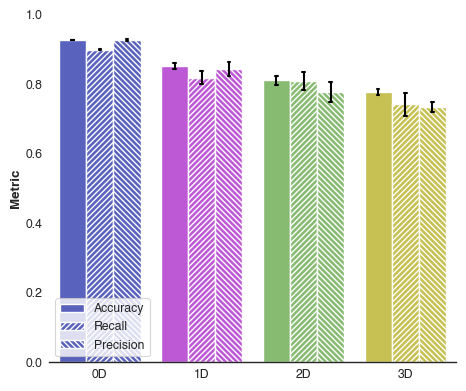

In [19]:
fig, ax = plt.subplots(figsize=(4.75,4))
sns.barplot(df.loc[df.target == "macro"], 
            x="split", 
            y="value", 
            hue="metric",
            palette=palette,
            errorbar=errorbar, 
            errcolor=errcolor,
            lw=linewidth,
            capsize=capsize / 4,
            errwidth=1.5,
            alpha=.99
           )

# Set the color of each bar manually
for i, bar in enumerate(ax.patches):
    bar.set_facecolor(palette[i % 4])
    if i in range(4, 8):
        bar.set_hatch("//////")
    if i in range(8, 12):
        bar.set_hatch("\\\\\\\\\\\\")  # need more to escape backslashes

ax.set_xlabel(None)
ax.set_ylabel("Metric")
ax.set_ylim((0, 1))

ax.legend(loc="lower left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / "best-model_metrics_2023-12-20_test-macro.pdf")

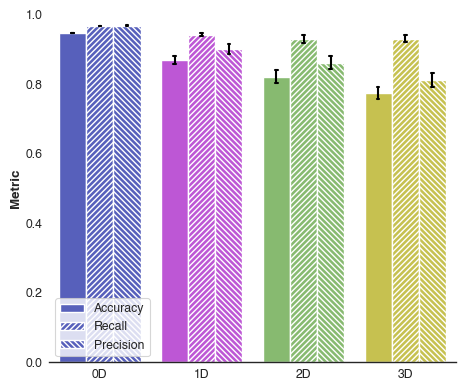

In [20]:
fig, ax = plt.subplots(figsize=(4.75,4))
sns.barplot(df.loc[df.target == "A"], 
            x="split", 
            y="value", 
            hue="metric",
            palette=palette,
            errorbar=errorbar, 
            errcolor=errcolor,
            lw=linewidth,
            capsize=capsize / 4,
            errwidth=1.5,
           )

# Set the color of each bar manually
for i, bar in enumerate(ax.patches):
    bar.set_facecolor(palette[i % 4])
    if i in range(4, 8):
        bar.set_hatch("//////")
    if i in range(8, 12):
        bar.set_hatch("\\\\\\\\\\\\")  # need more to escape backslashes

ax.set_xlabel(None)
ax.set_ylabel("Metric")
ax.set_ylim((0, 1))

ax.legend(loc="lower left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / "best-model_metrics_2023-12-20_test-A.pdf")